Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 36, 138])
 frog  bird plane horse


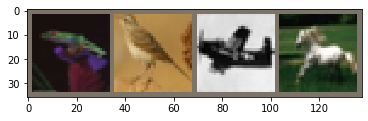

In [1]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from models.VGG16 import *


# =================================================== Prepare the dataset ===============================================================================

mean_cifar10 = [0.485, 0.456, 0.406]  # Mean and Std value hase been taken from a github implmentation online.
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 100
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

trainset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=True, download= True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # 10 Classes of the cifar-10

# ========================================== Visualising the dataset ==========================================================================
std= torch.FloatTensor(std_cifar10)
mean = torch.FloatTensor(mean_cifar10)
mean = mean[:,None,None]
std = std[:,None,None]
def imshow(img):
    print(img.size())
    img = img*std + mean     # unnormalize
    
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [2]:
# =============================================================== Model initialisation, Loss function and Optimizer =====================================
model = VGG16()
if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)
schedule = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma = 0.7)

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

14,775,646 total parameters.
14,775,646 trainable parameters.


In [3]:
model

VGG16(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout2d(p=0.3, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.4, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(

In [4]:
# ======================== Function to get the test accuracy ===============================================================================
def test():
  correct = 0
  total = 0
  model.train(False)
  with torch.no_grad():
    for i,(images,labels)in enumerate(testloader):
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
      outputs = model(Variable(images))
      labels = Variable(labels)
      _,predicted = outputs.max(1)
      total += labels.size(0)
      correct += (predicted.eq(labels)).sum().item()
    print('Test accuracy: %d %%' % (
  100 * correct / total))
  return 100*(correct/total)

#======================================================= Training =========================================================================
num_epochs = 150  # Train for 200 epochs
start_epoch = 0

total_step = len(trainloader)
train_loss = []  # Store the train_loss per epoch
test_accuracy = [] # Store the test_accuracy per epoch
for epoch in range(start_epoch,num_epochs):
  model.train(True)
  schedule.step()
  epoch_loss  = 0
  i_count = 0
  acc_total = 0
  for i,(images,labels) in enumerate(trainloader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    labels = Variable(labels)
    optimizer.zero_grad()
    outputs = model(Variable(images))
    loss = criterion(outputs,labels)
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
    _,predicted = outputs.max(1)
    denom = labels.size(0)
    correct = predicted.eq(labels).sum().item()
    acc = 100*(correct/denom)
    acc_total += acc
    i_count = i_count + 1
    
    #if(i%20 == 0):  # Print the loss per 20 iterations
      #print("Epoch: ",epoch," ","Iteration: ",i," loss: ",loss.item()," Train_iter Accuracy: ",acc)
  train_loss.append(epoch_loss)
  print("Epoch: ",epoch," ","Loss: ",epoch_loss," ","Train Accuracy :",acc_total/i_count) # Print train accuracy per epoch
  print('\n')
  test_acc = test()      # Print the test accuracy per epoch
  test_accuracy.append(test_acc)
  
  if(epoch%50 == 0):       # Save the model every 50 epoch
    state = {
        'model': model.state_dict(),
        'acc' : test_acc,
        'optim':optimizer.state_dict(),
        'epoch' : epoch
    }
    path = './base_noMaxpool_' + 'model_' + str(int(epoch)) +'_' + str(int(test_acc))+'.pth'
    torch.save(state,path)

/home/mlavrov/anaconda3/envs/meng/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch:  0   Loss:  1081.0219116210938   Train Accuracy : 17.598


Test accuracy: 15 %
Epoch:  1   Loss:  953.3859663009644   Train Accuracy : 26.65


Test accuracy: 27 %
Epoch:  2   Loss:  883.717242360115   Train Accuracy : 32.954


Test accuracy: 36 %
Epoch:  3   Loss:  835.3956513404846   Train Accuracy : 37.586


Test accuracy: 42 %
Epoch:  4   Loss:  799.9877156019211   Train Accuracy : 41.302


Test accuracy: 45 %
Epoch:  5   Loss:  764.4209824800491   Train Accuracy : 45.042


Test accuracy: 52 %
Epoch:  6   Loss:  727.0626668930054   Train Accuracy : 48.52


Test accuracy: 55 %
Epoch:  7   Loss:  691.8528804779053   Train Accuracy : 52.11


Test accuracy: 59 %
Epoch:  8   Loss:  649.9034715890884   Train Accuracy : 55.646


Test accuracy: 62 %
Epoch:  9   Loss:  617.1148545145988   Train Accuracy : 58.61


Test accuracy: 63 %
Epoch:  10   Loss:  589.4398677945137   Train Accuracy : 60.614


Test accuracy: 65 %
Epoch:  11   Loss:  559.3854498267174   Train Accuracy : 63.256


Te

In [5]:
#======================================= Testing ===================================================================================================
test_acc = test() # Test error
print(test_acc)

# Per class accuracy
class_correct = list(0. for i in range(10)) # Individual class error
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        images = Variable(images)
        labels = Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Test accuracy: 91 %
91.39
Accuracy of plane : 93 %
Accuracy of   car : 100 %
Accuracy of  bird : 84 %
Accuracy of   cat : 76 %
Accuracy of  deer : 91 %
Accuracy of   dog : 90 %
Accuracy of  frog : 94 %
Accuracy of horse : 96 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %
